In [194]:
pip install nltk


Note: you may need to restart the kernel to use updated packages.


In [195]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [196]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [197]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import re
import statistics as stats  
import matplotlib.pyplot as plt
import nltk

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.metrics import f1_score, precision_score, recall_score



In [198]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [199]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [200]:
# Load the data to inspect it
file_path =  "/teamspace/studios/this_studio/archive (3)/labeled_data.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [201]:
# Remove the unnecessary 'Unnamed: 0' column
data_cleaned = data.drop(columns=['Unnamed: 0'])

In [202]:
missing_values = data_cleaned.isnull().sum()


In [203]:
stop_words = set(stopwords.words('english'))

def clean_tweet(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove menções
    text = re.sub(r'@\w+', '', text)
    
    # Remove caracteres especiais e números, mantendo apenas letras e espaços
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Converte para minúsculas
    text = text.lower()
    
    # Divide o texto em palavras e remove as stop words
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # Junta as palavras de volta em uma string
    clean_text = ' '.join(words)
    
    return clean_text

In [204]:

def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

In [205]:
data_cleaned['tweet'] = data_cleaned['tweet'].apply(clean_text)


In [206]:
data_cleaned.head(), missing_values


(   count  hate_speech  offensive_language  neither  class  \
 0      3            0                   0        3      2   
 1      3            0                   3        0      1   
 2      3            0                   3        0      1   
 3      3            0                   2        1      1   
 4      6            0                   6        0      1   
 
                                                tweet  
 0   rt mayasolovely as a woman you shouldnt compl...  
 1   rt mleew boy dats coldtyga dwn bad for cuffin...  
 2   rt urkindofbrand dawg rt sbabylife you ever f...  
 3     rt cganderson vivabased she look like a tranny  
 4   rt shenikaroberts the shit you hear about me ...  ,
 count                 0
 hate_speech           0
 offensive_language    0
 neither               0
 class                 0
 tweet                 0
 dtype: int64)

In [207]:
data_cleaned.describe()

,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277
std,0.883060,0.631851,1.399459,1.113299,0.462089
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000


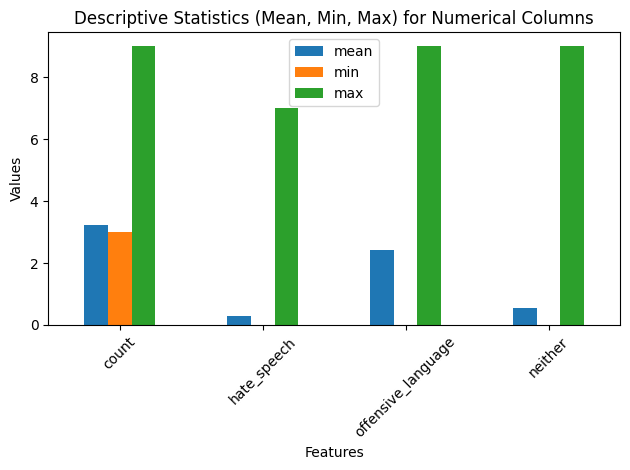

In [208]:
descriptive_stats = data_cleaned.describe()

stats_to_plot = descriptive_stats.loc[['mean', 'min', 'max'], ['count', 'hate_speech', 'offensive_language', 'neither']]

fig, ax = plt.subplots()

stats_to_plot.T.plot(kind='bar', ax=ax)

ax.set_title('Descriptive Statistics (Mean, Min, Max) for Numerical Columns')
ax.set_ylabel('Values')
ax.set_xlabel('Features')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [209]:
X_train, X_test, y_train, y_test = train_test_split(data_cleaned["tweet"], data_cleaned['class'], test_size=0.2, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [210]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

In [211]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

max_length = 0
for sequence in X_train:
    sequence_length = len(sequence)
    if sequence_length > max_length:
        max_length = sequence_length


print(max_length)

33


In [212]:
X_train = pad_sequences(X_train,maxlen=max_length,padding='post')
X_test = pad_sequences(X_test,maxlen=max_length,padding='post')

In [213]:
vocab_size = len(word_index) + 1
embedding_dim = 128
max_length = 25  # Tamanho máximo das sequências, definido previamente
l2_reg = 0.01  # Regularization term


In [214]:
X_train_padded = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

In [215]:
print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")

num test tweet: 4957
num train tweet: 19826


In [216]:
import tensorflow as tf

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.math.reduce_mean(tf.math.reduce_sum(loss, axis=-1))
    return focal_loss_fixed

In [217]:
model = Sequential([
    # Embedding layer
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    
    # Convolutional layer
    Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)),
    
    # Batch Normalization
    BatchNormalization(),
    
    # Max Pooling layer
    MaxPooling1D(pool_size=2),
    
    # LSTM layer with L2 regularization and dropout
    LSTM(32, dropout=0.4, recurrent_dropout=0.4, kernel_regularizer=l2(0.01)),
    
    # Dropout layer to prevent overfitting
    Dropout(0.5),
    
    # Dense layer with reduced units and L2 regularization
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    
    # Dropout
    Dropout(0.5),
    
    # Output layer with softmax activation
    Dense(3, activation='softmax'),
])

# Compile the model
model.compile(loss=focal_loss(gamma=2., alpha=0.25), optimizer='adam', metrics=['accuracy'])


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [218]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, train_data):
        super().__init__()
        self.validation_data = validation_data
        self.train_data = train_data
        self.train_accuracy = []
        self.val_accuracy = []
        self.train_f1 = []
        self.val_f1 = []
        self.train_precision = []
        self.val_precision = []
        self.train_recall = []
        self.val_recall = []

    def on_epoch_end(self, epoch, logs=None):
        # Prever no conjunto de validação
        val_X, val_y = self.validation_data
        y_pred_val = (self.model.predict(val_X) > 0.5).astype("int32")
        
        # Prever no conjunto de treino
        train_X, train_y = self.train_data
        y_pred_train = (self.model.predict(train_X) > 0.5).astype("int32")

        # Calcular as métricas no conjunto de validação
        val_f1 = f1_score(val_y, y_pred_val, average='weighted', zero_division=0)
        val_precision = precision_score(val_y, y_pred_val, average='weighted', zero_division=0)
        val_recall = recall_score(val_y, y_pred_val, average='weighted', zero_division=0)

        # Calcular as métricas no conjunto de treinamento
        train_f1 = f1_score(train_y, y_pred_train, average='weighted', zero_division=0)
        train_precision = precision_score(train_y, y_pred_train, average='weighted', zero_division=0)
        train_recall = recall_score(train_y, y_pred_train, average='weighted', zero_division=0)

        # Armazenar as métricas
        self.train_accuracy.append(logs['accuracy'])
        self.val_accuracy.append(logs['val_accuracy'])
        self.train_f1.append(train_f1)
        self.val_f1.append(val_f1)
        self.train_precision.append(train_precision)
        self.val_precision.append(val_precision)
        self.train_recall.append(train_recall)
        self.val_recall.append(val_recall)

        # Exibir as métricas no final de cada época
        print(f"\nEpoch {epoch + 1} - Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Val F1: {val_f1:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")


In [219]:
def plot_metrics(metrics_callback):
    epochs = range(1, len(metrics_callback.train_accuracy) + 1)

    # Plotando a acurácia
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, metrics_callback.train_accuracy, label='Train Accuracy')
    plt.plot(epochs, metrics_callback.val_accuracy, label='Val Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotando o F1-Score
    plt.subplot(2, 2, 2)
    plt.plot(epochs, metrics_callback.train_f1, label='Train F1-Score')
    plt.plot(epochs, metrics_callback.val_f1, label='Val F1-Score')
    plt.title('F1-Score per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()

    # Plotando a precisão
    plt.subplot(2, 2, 3)
    plt.plot(epochs, metrics_callback.train_precision, label='Train Precision')
    plt.plot(epochs, metrics_callback.val_precision, label='Val Precision')
    plt.title('Precision per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Plotando o recall
    plt.subplot(2, 2, 4)
    plt.plot(epochs, metrics_callback.train_recall, label='Train Recall')
    plt.plot(epochs, metrics_callback.val_recall, label='Val Recall')
    plt.title('Recall per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [220]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [221]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [222]:
print("Classes únicas no conjunto de treino:", np.unique(y_train))


Classes únicas no conjunto de treino: [0. 1.]


In [223]:
print(f"Tipo de y_train: {y_train.dtype}")
y_train = y_train.astype('int')


Tipo de y_train: float64


In [224]:
class_weights_dict = {
    0: 2.0,  # Higher weight for class 0 (minority)
    1: 1.0,  # Default weight for class 1 (dominant class)
    2: 1.5   # Somewhat higher weight for class 2 (moderate class)
}

In [225]:
metrics_callback = MetricsCallback(validation_data=(X_test_padded, y_test), train_data=(X_train_padded, y_train))


In [226]:
# Treinamento do modelo
history = model.fit(
    X_train_padded,           # Dados de treino após padding
    y_train,                 # Rótulos de treino
    epochs=15,               # Número de épocas
    batch_size=32,                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
    validation_data=(X_test_padded, y_test),  # Dados de validação
    callbacks=[early_stopping, metrics_callback],
    verbose=2,                # Nível de detalhamento do output
    class_weight=class_weights_dict  # Pass the class weights here
)

# Avaliar o modelo nos dados de teste
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=2)
print(f'Acurácia no conjunto de teste: {test_accuracy}')


Epoch 1/15


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Epoch 1 - Train F1: 0.7321, Train Precision: 0.7209, Train Recall: 0.7436
Val F1: 0.7174, Val Precision: 0.6976, Val Recall: 0.7383
620/620 - 14s - 22ms/step - accuracy: 0.7941 - loss: 0.2520 - val_accuracy: 0.8158 - val_loss: 0.0542
Epoch 2/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Epoch 2 - Train F1: 0.8933, Train Precision: 0.8801, Train Recall: 0.9075
Val F1: 0.8463, Val Precision: 0.8456, Val Recall: 0.8505
620/620 - 11s - 17ms/step - accuracy: 0.8864 - loss: 0.0516 - val_accuracy: 0.8820 - val_loss: 0.0454
Epoch 3/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Epoch 3 - Train F1: 0.8923, Train Precision: 0.8803, Train Recall: 0.9089
Val F1: 0.8313, Val Precision: 0.8351, Val Recall: 0.8455
620/620 - 11s - 17ms/step - accuracy: 0.9111 - loss: 0.0438 - val_accuracy: 0.8675 - val_loss: 0.0620
Epoch 4/15
155/155 ━━━━━━━━

In [227]:
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=2)
print(f'Acurácia no conjunto de teste: {test_accuracy}')

155/155 - 0s - 2ms/step - accuracy: 0.8820 - loss: 0.0454
Acurácia no conjunto de teste: 0.881985068321228


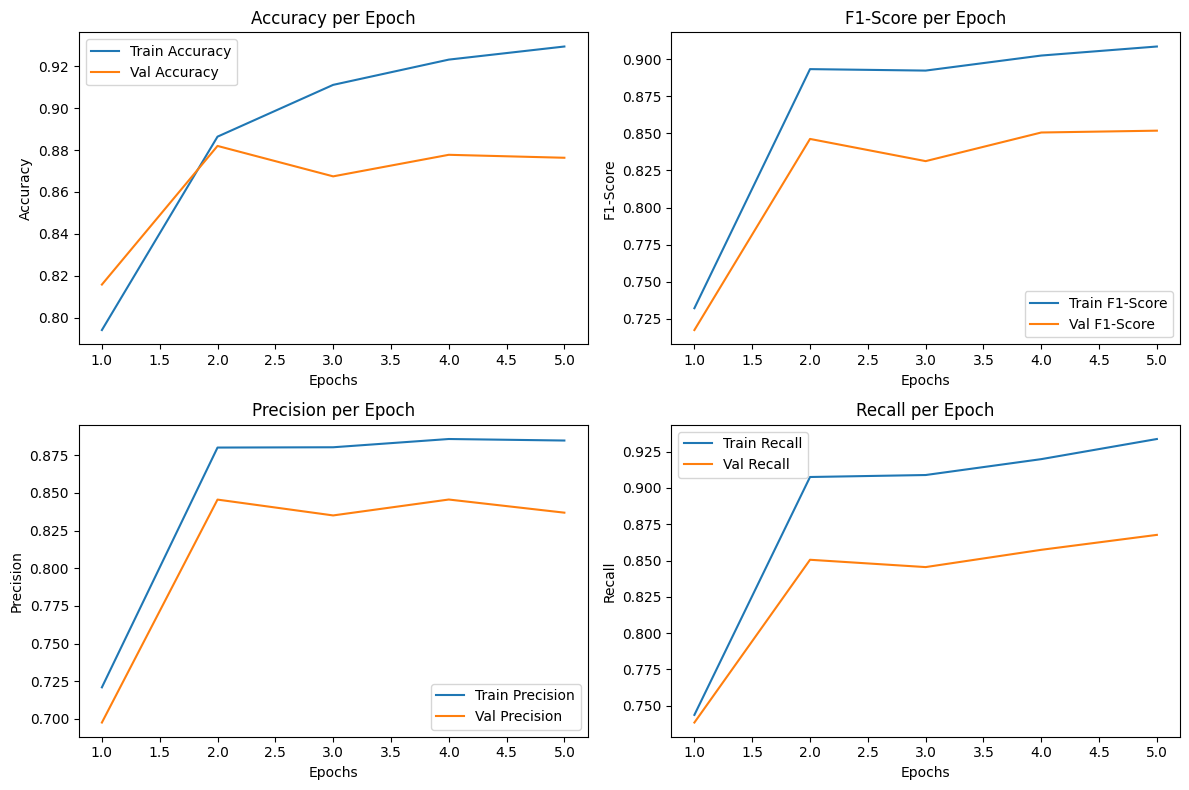

In [228]:
plot_metrics(metrics_callback)
